# Time Series Classification using Gramian Angular Fields and FastAI

## Introduction

This notebook demonstrates how to use Gramian Angular Fields (GAFs) for time series classification using the FastAI library. We'll be working with a binary classification problem using time series data.

GAFs are a method of encoding time series data as images. This transformation allows us to apply powerful image classification techniques to time series problems. GAFs capture temporal dependencies by representing time series in a polar coordinate system and then applying trigonometric functions.

Throughout this notebook, we'll cover the following steps:
1. Loading and exploring the dataset
2. Converting time series to Gramian Angular Fields
3. Preparing the data for training
4. Creating and training a convolutional neural network
5. Evaluating the model's performance

This project serves as an introduction to using image-based techniques for time series classification and showcases the simplicity and power of the FastAI library combined with GAFs.

In [1]:
%%capture

# Import required libraries
!pip install -r requirements.txt

from fastai.vision.all import *
from fastai.interpret import Interpretation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sktime.datasets import load_gunpoint
from pyts.image import GramianAngularField
from skimage.transform import resize

## Data Loading and Exploration

In [2]:
# Load the GunPoint dataset
X, y = load_gunpoint(return_X_y=True)

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class labels: {np.unique(y)}")

Dataset shape: (200, 1)
Number of classes: 2
Class labels: ['1' '2']


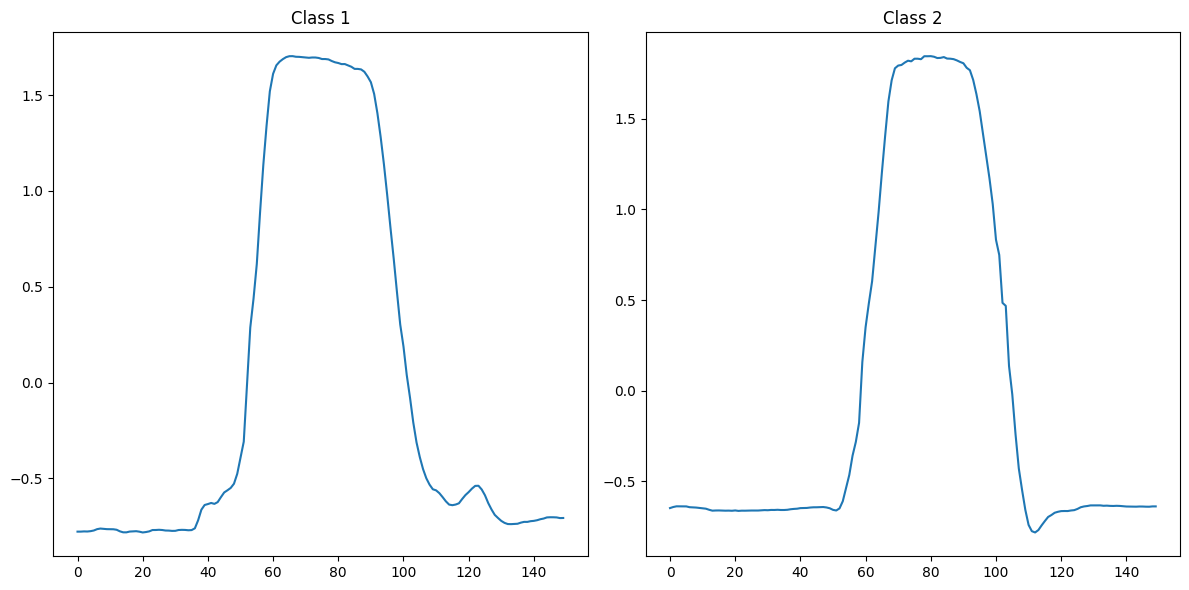

In [3]:
# Display sample time series
plt.figure(figsize=(12, 6))
for i, label in enumerate(['1', '2']):
    plt.subplot(1, 2, i+1)
    sample = X[y == label].iloc[0, 0]  # Get the first time series of this class
    plt.plot(sample)
    plt.title(f"Class {label}")
plt.tight_layout()
plt.show()

In [4]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 160
Test set size: 40


## Convert Time Series to Gramian Angular Fields

In [5]:
# Determine the number of timestamps dynamically
n_timestamps = len(X_train.iloc[0, 0])
print("Number of timestamps:", n_timestamps)

# We use the length of the first time series to determine the number of timestamps.
# This will be used to set the size of our GAF images.

Number of timestamps: 150


In [6]:
# Initialize the GAF transformer
gaf = GramianAngularField(image_size=n_timestamps, method='summation')

# We create a GAF transformer that will convert our time series into images.
# The 'summation' method is one way to calculate the GAF; alternatives include 'difference'.

In [7]:
# Convert time series to GAF images
stacked_data = np.vstack(X_train.iloc[:, 0].values)
print("Stacked data shape:", stacked_data.shape)

Stacked data shape: (160, 150)


In [8]:
X_train_gaf = gaf.fit_transform(stacked_data)
X_test_gaf = gaf.transform(np.vstack(X_test.iloc[:, 0].values))

print(f"GAF image shape: {X_train_gaf.shape[1:]}")

GAF image shape: (150, 150)


In [9]:
# Resize GAF images to 224x224 for compatibility with standard CNN architectures
def resize_gaf(gaf_images, target_size=(224, 224)):
    return np.array([resize(img, target_size) for img in gaf_images])

X_train_gaf_resized = resize_gaf(X_train_gaf)
X_test_gaf_resized = resize_gaf(X_test_gaf)

print(f"Resized GAF image shape: {X_train_gaf_resized.shape[1:]}")

Resized GAF image shape: (224, 224)


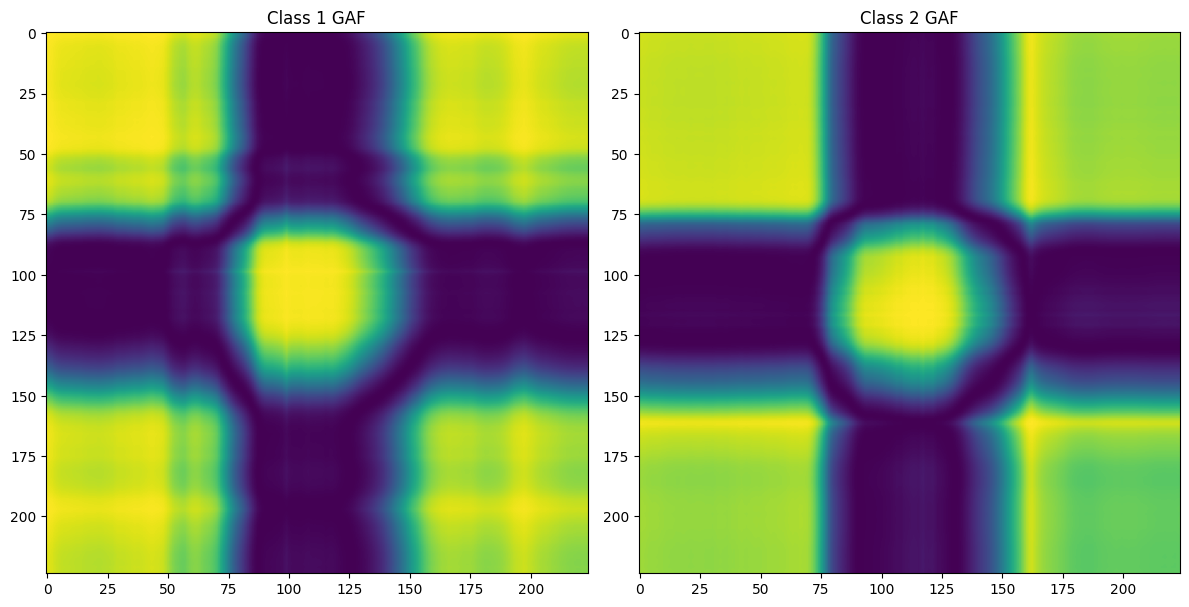

In [10]:
# Display sample GAF images for each class
plt.figure(figsize=(12, 6))
for i, label in enumerate(['1', '2']):
    plt.subplot(1, 2, i+1)
    sample_gaf = X_train_gaf_resized[y_train == label][0]
    plt.imshow(sample_gaf, cmap='viridis')
    plt.title(f"Class {label} GAF")
plt.tight_layout()
plt.show()

## Prepare Data for FastAI

In [11]:
# Convert GAF images and labels to FastAI format
train_gaf_data = list(zip(X_train_gaf_resized, y_train))
test_gaf_data = list(zip(X_test_gaf_resized, y_test))
path = Path('.')
(path/'gaf_images'/'train').mkdir(parents=True, exist_ok=True)
(path/'gaf_images'/'test').mkdir(parents=True, exist_ok=True)

for i, (img, label) in enumerate(train_gaf_data):
    im = Image.fromarray((img * 255).astype(np.uint8))
    im.save(path/'gaf_images'/'train'/f'img_{i}_{label}.png')

for i, (img, label) in enumerate(test_gaf_data):
    im = Image.fromarray((img * 255).astype(np.uint8))
    im.save(path/'gaf_images'/'test'/f'img_{i}_{label}.png')

In [12]:
# Define the get_label function
def get_label(fname):
    return fname.name.split('_')[-1].split('.')[0]

# Create FastAI DataLoaders
dls = ImageDataLoaders.from_path_func(
    path/'gaf_images'/'train',  # Use the train directory
    get_image_files(path/'gaf_images'/'train'),  # Get files from train directory
    get_label,  # Use our get_label function
    valid_pct=0.2,
    item_tfms=Resize(224)
)

# Verify the labels
print("\nUnique labels:")
print(dls.vocab)


Unique labels:
['1', '2']


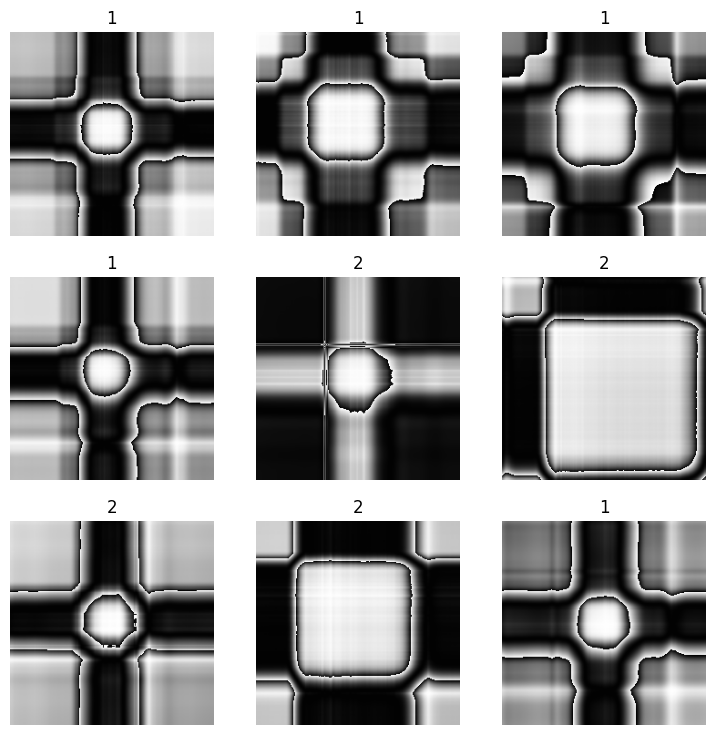

In [13]:
# Display a batch of images
dls.show_batch()

## Model Creation and Training

In [14]:
# Create and train the model
# Create the model with the correct number of outputs
learn = vision_learner(dls, resnet34, metrics=error_rate, n_out=2)

# Train the model
learn.fine_tune(5)  # Train for 5 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.944407,0.833586,0.500000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.594267,0.372621,0.218750,00:00
1,0.328074,0.058225,0.000000,00:00
2,0.230798,0.012140,0.000000,00:00
3,0.169969,0.005066,0.000000,00:00
4,0.133283,0.003919,0.000000,00:00


## Model Evaluation

In [15]:
# Validation accuracy
val_preds, val_targets = learn.get_preds(dl=dls.valid)
val_pred_labels = val_preds.argmax(dim=1)
val_accuracy = accuracy_score(val_targets, val_pred_labels)
print(f"Validation accuracy: {val_accuracy:.4f}")

Validation accuracy: 1.0000


In [16]:
# Create test set DataLoader
test_files = get_image_files(path/'gaf_images'/'test')
test_dl = learn.dls.test_dl(test_files)

In [17]:
# Get predictions on test set
predictions, _ = learn.get_preds(dl=test_dl)
predicted_labels = predictions.argmax(dim=1)
true_labels = torch.tensor([int(f.name.split('_')[-1].split('.')[0]) for f in test_files])

# Adjust predicted labels to match true labels (0 -> 1, 1 -> 2)
predicted_labels_adjusted = predicted_labels + 1

In [18]:
# Calculate and display accuracy
accuracy = accuracy_score(true_labels, predicted_labels_adjusted)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 1.0000


In [19]:
# Display classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels_adjusted, target_names=['1', '2']))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        16

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



### Interpreting the Results

The classification report provides several metrics:
- Precision: The ratio of correctly predicted positive samples to the total predicted positive samples.
- Recall: The ratio of correctly predicted positive samples to all actual positive samples.
- F1-score: The harmonic mean of precision and recall, providing a single score that balances both metrics.
- Support: The number of samples for each class.

These metrics help us understand how well our model performs for each class and overall.
A high F1-score indicates good balance between precision and recall.

The accuracy score we calculated earlier gives us an overall measure of the model's performance.
However, it's important to look at the per-class metrics to ensure the model performs well for all classes.

### Calibration Table / Reliability Diagram Table

This table shows how well the model's predicted probabilities (confidence) align with the actual observed frequencies of correct predictions.
A well-calibrated model should have similar values in the 'Confidence Bin' and corresponding accuracy columns.
For example, in the 0.8-0.9 confidence bin, we'd expect the accuracy to be around 80-90%.

The table breaks down the results by class, allowing us to see if the model is better calibrated for one class over the other.

In [20]:
# Get the probabilities for the predicted class
confidences, _ = torch.max(predictions, dim=1)

# Create a DataFrame with our data
df = pd.DataFrame({
    'confidence': confidences.numpy(),
    'correct': (predicted_labels_adjusted == true_labels).numpy(),
    'true_label': true_labels.numpy()
})

# Create bins
bins = np.linspace(0, 1, 11)
df['bin'] = pd.cut(df['confidence'], bins)

# Group by bin and calculate metrics
result = df.groupby('bin', observed=True).agg({
    'correct': 'mean',
    'true_label': ['count', lambda x: (x == 1).sum()]
}).reset_index()

result.columns = ['Confidence Bin', 'Total Accuracy', 'Total Count', 'Class 1 Count']
result['Class 2 Count'] = result['Total Count'] - result['Class 1 Count']

# Calculate accuracies separately for each class
class_1_accuracy = df[df['true_label'] == 1].groupby('bin', observed=True)['correct'].mean()
class_2_accuracy = df[df['true_label'] == 2].groupby('bin', observed=True)['correct'].mean()

result['Class 1 Accuracy'] = result['Confidence Bin'].map(class_1_accuracy).fillna(0)
result['Class 2 Accuracy'] = result['Confidence Bin'].map(class_2_accuracy).fillna(0)

# Convert accuracies to percentages
accuracy_columns = ['Class 1 Accuracy', 'Class 2 Accuracy', 'Total Accuracy']
result[accuracy_columns] = result[accuracy_columns] * 100

# Format the confidence bins
result['Confidence Bin'] = result['Confidence Bin'].apply(lambda x: f"{x.left:.1f}-{x.right:.1f}")

# Reorder columns
result = result[['Confidence Bin', 'Class 1 Accuracy', 'Class 1 Count', 
                 'Class 2 Accuracy', 'Class 2 Count', 
                 'Total Accuracy', 'Total Count']]

# Display the formatted table
display(result.style.format({
    'Class 1 Accuracy': '{:.0f}%',
    'Class 2 Accuracy': '{:.0f}%',
    'Total Accuracy': '{:.0f}%',
    'Class 1 Count': '{:,}',
    'Class 2 Count': '{:,}',
    'Total Count': '{:,}'
}))

,Confidence Bin,Class 1 Accuracy,Class 1 Count,Class 2 Accuracy,Class 2 Count,Total Accuracy,Total Count
0,0.6-0.7,0%,0,100%,1,100%,1
1,0.9-1.0,100%,24,100%,15,100%,39


## Conclusion

In this notebook, we've demonstrated how to:
1. Convert time series data into Gramian Angular Field images
2. Use these images to train a deep neural network for classification
3. Evaluate the model's performance using various metrics

Key takeaways:
- GAFs provide a way to leverage image classification techniques for time series data
- FastAI simplifies the process of training and evaluating deep learning models
- It's important to look beyond overall accuracy and consider per-class performance and model calibration

Next steps could include:
- Experimenting with different GAF parameters (e.g., image size, method)
- Trying other image-based time series representations (e.g., Markov Transition Fields)
- Applying this technique to other time series classification problems